# Movie Recommender Systems

### **2019/11/14 CoE 202 Activity 3**

***Tip> shotcuts for Jupyter Notebook***
* Shift + Enter : run cell and select below

**(!! Important) In this activity, we excute our model using GPU. Change Hardware Accelerator.**</br>
Edit > Notebook settings or Runtime > Change runtime type and select GPU as Hardware accelerator.</br>
런타입 > 런타입 유형 변경 > 하드웨어 가속기 > GPU</br>
</br>


### Upload the data that you need to Google server
These files are in data folder.
1. ratings.csv
2. movies.csv 
3. fig1.png (the above picture, optional)


In [0]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

In [0]:
from IPython.display import Image
Image(filename="/content/fig1.png", width="1000") # If you can't see figure, then upload /img/fig1.png by executing the under code cell.

<center>Fig. 1 Item-based autoencoder </center>

A recommender system is a subclass of information filtering system that seeks to predict the "rating" or "preference" a user would give to an item.<br/>
In Project 3, this recommender system is a system to estimate ratings of other movies using ratings from other users similar to those of one user.<br/>
And an autoencoder is a neural network that learns to copy its input to its output. It has an internal(hidden) layer that describes a code used to represent the input, and it is constituted by two main parts: an encoder that maps the input into the code, and a decoder that maps the code to a reconstruction of the original input.</br>
A item based autoencoder use the ratings of many users in a movie. In other words, the item based autoencoder use column vector of input matrix.</br> 
A user based autoencoder ues the ratings of many movies in a user. In other words, the user based autoencoder use row vector of input matrix. but in General, the user based autoencoder has less performance than the item based autoencoder. So we use the item based autoencoder.</br>
</br>
#### Objective> Train deep neural network (autoencoder) to complete movie rating matrix
- #### Loss function

$$L(M, \hat{M})=\sum_{(i,j)\in E}(M_{ij}-\hat{M}_{ij})^2 + \lambda\sum_{i=1}^{3}\lVert W_i\rVert^2_2$$
<br/>
- #### Update weight and bias
$$\underset{W, b}{\text{argmin}}\hspace{0.2em} L(M, \hat{M})$$

### Import Library for this project

In [1]:
import numpy as np
import tensorflow as tf
%tensorflow_version 1.x
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import time

## 1. Prepare data

### MovieLens Dataset (ref.)
We use "MovieLens Latest Datasets" consisting of 100,000 ratings applied to 9,000 movies by 600 users. Last updated 9/2018.</br>
### Fetch MovieLens data
All ratings are contained in the file `ratings.csv`. Each line of this file after the header row represents one rating of one movie by one user, and has the following format : userId, movieId, rating, timestamp. The lines within this file are ordered first by userId, then, within user, by movieId. Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars). Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

In [2]:
rating = pd.read_csv('ratings.csv')
rating.head(10)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400
6,1,101,5.0,964980868
7,1,110,4.0,964982176
8,1,151,5.0,964984041
9,1,157,5.0,964984100


### Ratings statistics
Count the number of movies with identical rating.

In [3]:
rating.set_index(["userId", "timestamp","rating"]).count(level="rating").rename({'movieId': 'The number of movies'}, axis='columns')

,The number of movies
rating,
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


Count the number of users and movies and check the sparsity<br/>
There are 610 distinct user and 9724 moives, and sparsity is 1.7%.<br/>
And rating.csv contains 100836 (userID, movieID, rating, timestemps) pairs.

In [4]:
n_user = len(rating['userId'].unique())
n_movie = len(rating['movieId'].unique())
n_rating = len(rating['rating'])
print("[*] %d users & %d movies" % (n_user, n_movie))
print(n_rating)
print("[*] Sparsity: %.2f%%" % (n_rating / (n_user * n_movie) * 100))

[*] 610 users & 9724 movies
100836
[*] Sparsity: 1.70%


### Movie list
See the movie list including movies' title and genres.<br/>
Movie information is contained in the file `movies.csv`. Each line of this file after the header row represents one movie, and has the following format : movieId,title,genres. Movie titles are entered manually or imported from <https://www.themoviedb.org/>, and include the year of release in parentheses. Errors and inconsistencies may exist in these titles. Genres are a pipe-separated list

In [5]:
movielist = pd.read_csv('movies.csv')
movielist.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


Drop **"timestamp"** which looks useless in rating(ratings.csv).<br/>
We can look at the movie list, there is a movie name and corresponding movie ID. And we can see the genre that corresponds to each movieID. A recommend system will use the genre of the moives to approximately estimate similarity of other movie. And the system will estimate(recommend) a user's empty ratings. Therefore, We don't need timestemp.</br>
In fact, we don't use genres because we implement simple recommend system. But i wish that you see how a recommend system works

In [6]:
rating.drop(['timestamp'], axis=1, inplace=True)
rating.tail()

,userId,movieId,rating
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0
100835,610,170875,3.0


Scale **"movieId"** in between 0 and 9723, **"userId"** in between 0 and 609<br/></br>
Use pandas.factorize() to using input data converted to numerical data.<br/> 
labels(Numeric Representation), values = pandas.factorize()

In [7]:
rating['movieId'], _ = pd.factorize(rating['movieId'])
rating['userId'], _ = pd.factorize(rating['userId'])
rating.tail()

,userId,movieId,rating
100831,609,3120,4.0
100832,609,2035,5.0
100833,609,3121,5.0
100834,609,1392,5.0
100835,609,2873,3.0


### Item-based autoencoder
Rearrange the rating matrix

In [8]:
rating = rating[['movieId', 'userId', 'rating']]
rating.head()

,movieId,userId,rating
0,0,0,4.0
1,1,0,4.0
2,2,0,4.0
3,3,0,5.0
4,4,0,5.0


### Split the ratings for training and test
Training : Test = 9 : 1<br/>
Divide data set by training data set and training data set by ratio 9:1.<br/>
Shape of rating(entire data set) is 100836 $*$ 3</br>
Shape of ratingTrain(training data set) is 90752 $*$ 3</br>
Shape of ratingTest(test data set) is 10084 $*$ 3</br>
</br>
pandas.random.choice(range, size, replace)<br/>
pandas.iloc() : bring the rows of the corresponding index<br/>
And convert pandas.iloc() to numpy array to use.<br/>
d1 is number of movies(9724), d2 is number of users(610)


In [0]:
trainIdx = np.random.choice(range(n_rating), int(n_rating * 0.9), replace=False)
dataTrain = rating.iloc[trainIdx]

testIdx = np.setdiff1d(range(n_rating), trainIdx)
dataTest = rating.iloc[testIdx]

In [10]:
ratingTrain = np.asarray(dataTrain)
ratingTest = np.asarray(dataTest)
print(ratingTrain.shape)
print(ratingTest.shape)
d1, d2 = np.max(ratingTrain[:, 0]) + 1, np.max(ratingTrain[:, 1] + 1)

(90752, 3)
(10084, 3)


## 2. Build a Graph
First, make edge(weight) by using matrix representation, and nodes using placeholder. Second, open session to implement our graph(structure of NN). Third, give feed_dict(input of graph) to graph and excute sess.run(learning NN). 

### Make edge for weight of NN
We use "tf.sparse_tensor_dense_matmul()" function instead of  "tf.layers.dense( )" function, because of the sparse input and regularization.</br>
sparse input(sparse vector) is a vector in which most of the elements are zero. So, sparse input is represented to the input that each user rated for only a few of movies. In fact, since user didn't rate all movies, most of rating element are blank. Thus zero means blank because Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars). So we input matrix of NN is declared SparseTensor, not typical Tensor. Hence we use "tf.sparse_tensor_dense_matmul()". cf. dense input(dense matrix) is a vector or matrix in which all of elements are non-zero, i.e. all rate of user is not zero.</br>
In case that input is sparse tensor, if you use tf.sparse_tensor_dense_matmul(), then you can compute to use more efficient memory and more faster speed than using a typical tensor matrix multipy.</br>
</br>
Our graph take input X(?$*$d2 matrix), where ? means that size is not assigned yet. in fact, our feed_dict is d1$*$d2 matrix. => in 1st layer, X$*$W1+b1(d1$*$d2$*$d2$*$100 + d1$*$100) => in 2nd layer, h1$*$w2+b2(d1$*$100$*$100$*$50+d1$*$50)  => in last layer, h2$*$w3(d1$*$50$*$50$*$d2) => shape of X is the same with shape of yhat (that is autoencoder)</br>
</br>
tf.sparse_tensor_dense_matmul() : function allows multiplying a sparse matrix by a dense matrix by converting blank nodes to zero.</br>
tf._.initializer() : intialize weight for initial learning</br>
tf.get_variable(name, shape, ) : get an existing variable with parameter. If there are no parameters, then create one. </br>
tf.matmul() : matrix multiplication</br>
tf.gather_nd() : gather slices into the output tensor with shape specified by indices. In other words, get yhat of specified user  </br>
tf.nn.l2_loss() : variable to the power of 2 </br>
tf.reduce_sum() : Summation</br>
var.op.name.find('weight') : find position of 'weight' in var.op.name. i.e. 'weight1'.find('weight')=0, 'abc'.find('c')=2, 'abc.find('d')=-1.</br>
var.op.name : name of variable is determined by operator that generated variable. i.e. w1 = tf.get_variable('weight1', [d2, _units[0]], initializer=w_init) => w1.op.name = weight1

In [0]:
def autoencoder(_X, _units, _l2_lambda, _n_ratings):
    w_init = tf.contrib.layers.variance_scaling_initializer()
    b_init = tf.constant_initializer(0.)
    
    ## Encoder
    '1st Hidden layer'
    w1 = tf.get_variable('weight1', [d2, _units[0]], initializer=w_init)
    b1 = tf.get_variable('biases1', [_units[0]], initializer=b_init)
    h1 = tf.sparse_tensor_dense_matmul(_X, w1) + b1
    # Dropout to the output of layer 1 which would be the input of layer 2.
    h1 = tf.layers.dropout(h1)
    # Batch Normalization of output of layer 1 which would be the input of layer 2.
    h1 = tf.layers.batch_normalization(h1, training = True)
    h1 = tf.nn.relu(h1)

    '2nd Hidden layer'
    w2 = tf.get_variable('weight2', [_units[0], _units[1]], initializer=w_init)
    b2 = tf.get_variable('biases2', [_units[1]], initializer=b_init)
    h2 = tf.matmul(h1, w2) + b2
    # Dropout to the output of layer 2 which would be the input of decoder.
    h2 = tf.layers.dropout(h2)
    # Batch Normalization of output of layer 1 which would be the input of layer 2.
    h2 = tf.layers.batch_normalization(h2, training = True)
    h2 = tf.nn.sigmoid(h2)

    # If you want to simplify the above code, 
    # use tf.layers.dense(inputs, units, activation)
    # i.e. 2st hidden layer => tf.layers.dense(_X, units[0], activation=tf.nn.sigmoid)
    
    ## Decoder
    w3 = tf.get_variable('weight3', [_units[1], d2], initializer=w_init)
    
    yhat = tf.matmul(h2, w3)
    out = tf.gather_nd(yhat, _X.indices)

    loss = tf.reduce_sum(tf.pow(out - _X.values, 2)) / _n_ratings
    
    
    ''' L2 regularization '''
    all_var = [var for var in tf.trainable_variables() ]
    l2_losses = []
    for var in all_var:
        if var.op.name.find('weight') == 0:
            l2_losses.append(tf.nn.l2_loss(var))
    
    losses = loss + _l2_lambda * tf.reduce_sum(l2_losses)
    
    return yhat, losses

### Set hyperparameters
- ***n_epochs*** : The number of epochs
- ***lr*** : Learning rate for gradient descent
- ***l2_lambda*** : regularization parameter
- ***n_units*** : The number of units for each hidden layer
- ***n_ratings*** : The number of training data set

In [0]:
"""parameters"""
n_epochs = 10000
lr = 0.1
l2_lambda = 0.003
n_units = [100, 50]
n_ratings = len(ratingTrain)
display_step = n_epochs / 10

### Placeholder for sparse input data
Make nodes for input into the graph made above.</br>
Since our input is sparse data input, declare X with SparseTensor, not typical Tensor, using tf.sparse_placeholder().</br>
The size of x is not assigned in order not to specify the size of the matrix(or vector) that represent input.</br>
The size of the input may be different, i.e. size of input of traing data set and test data set are different, so do not specify the size of the node. Just when the feed_dict comes in X, the size of the X is flexiblely fitted the feed_dict size.</br>
</br>
tf.sparse_placeholder(datatype, shape=None, name=None) : make nodes as SparseTensor. SparseTensor has value(element) and corresponding index. So, SparseTensor allow that nodes are blank. This is what difference are between tf.placeholder() and tf.sparse_placeholder(), Tensor and SparseTensor.</br>
tf.placeholder(datatype, shape=None, name=None) : make a Tensor that may be used as a handle for feeding a value, but not evaluated directly. It is dense matrix of which there are not blank element.

In [0]:
# tf Graph input
X = tf.sparse_placeholder(dtype=tf.float32)
is_train = tf.placeholder(dtype=tf.bool)

### Use the GradientDescentOptimizer
So far, we have made graph, but we don't assign the size of edge(matrix representation of weights and bias). Let's assign size of edge.</br>
</br>
autoencoder() : the above graph</br>
tf.Variable(_, trainable) : get variable, If trainalbe is True, add the variable to the graph collection</br>
global_step : Optional Variable to increment by one after the variables have been updated. So, global step is variable that represents current step of minimizing. but we don't need it, so global_step is just zero.

In [14]:
pred, cost = autoencoder(X, n_units, l2_lambda, n_ratings)
global_step = tf.Variable(0, trainable=False)

#Use MomentumOptimizer with learning rate of 0.1 and momentum of 0.9
optimizer = tf.train.MomentumOptimizer(learning_rate=lr,momentum=0.9).minimize(cost, global_step=global_step)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Create a tensorflow session (EXCUTION PHASE)
Tensorflow operations must be executed in the session. The only one session is activated.</br>
We must excute NN in the session to learn the neural network we have created.</br>
</br>
tf.global_variables_initializer() : initializes all weight and bias of NN. 


In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

## 3. Training
inputs(feed dictionary) of our graph are ([movieId	userId], [rating], [# of movies, # of users]), and keyword of feed_dict is X.</br>
We implement our NN to get optimizer and cost function value using feed_dict.</br>
feed = {X: (ratingTrain[:, 0:2], ratingTrain[:, 2], [d1, d2])}</br>
At the previous code, we make nodes(called X) as sparse tensor, SparseTensor is declared in the form (indices, values, shape).</br>
=> we assign feed to matrix with shape(d1$*$d2), where row index is movieID, column index is UserID, element of matrix is Rating in ratingTrain.</br>
So, most of element of this matrix is blank, because we have sparse input.</br>
But since we use tf.sparse_tensor_dense_matmul() and tf.sparse_placeholder(), it is okay.</br>
</br>
sess.run((learning objective functions), feed_dictionary) : update NN over cost function using assigned optimizer method by give feed dictionary

In [16]:
print("START OPTIMIZATION\n")
start_time = time.time()
losses = []
for epoch in  range(n_epochs + 1):
    feed = {X: (ratingTrain[:, 0:2], ratingTrain[:, 2], [d1, d2])}
    _, avg_cost = sess.run((optimizer, cost), feed_dict = feed)
    losses.append(np.sqrt(avg_cost))

    # DISPLAY
    if epoch % display_step == 0:
        duration = float(time.time() - start_time)
        print(" [*] Epoch: %05d/%05d cost: %2e (Computing time: %.3fs)" % (epoch, n_epochs, np.sqrt(avg_cost), duration))
        start_time = time.time()
print("\nOptimization Finished!")

START OPTIMIZATION

 [*] Epoch: 00000/10000 cost: 4.026352e+00 (Computing time: 0.948s)
 [*] Epoch: 01000/10000 cost: 9.428052e-01 (Computing time: 5.159s)
 [*] Epoch: 02000/10000 cost: 9.161591e-01 (Computing time: 5.204s)
 [*] Epoch: 03000/10000 cost: 9.134590e-01 (Computing time: 5.195s)
 [*] Epoch: 04000/10000 cost: 9.023877e-01 (Computing time: 5.164s)
 [*] Epoch: 05000/10000 cost: 8.976070e-01 (Computing time: 5.420s)
 [*] Epoch: 06000/10000 cost: 8.948933e-01 (Computing time: 5.411s)
 [*] Epoch: 07000/10000 cost: 8.970872e-01 (Computing time: 5.069s)
 [*] Epoch: 08000/10000 cost: 9.006460e-01 (Computing time: 5.279s)
 [*] Epoch: 09000/10000 cost: 8.951634e-01 (Computing time: 5.073s)
 [*] Epoch: 10000/10000 cost: 8.911020e-01 (Computing time: 5.220s)

Optimization Finished!


### plot leaning curve

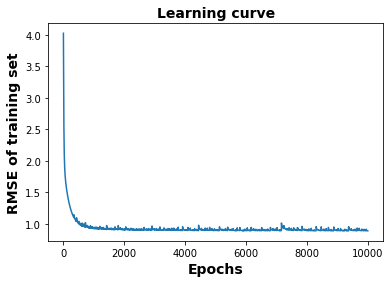

In [17]:
plt.plot(losses)
plt.title("Learning curve", fontsize=14, fontweight='bold')
plt.xlabel("Epochs", fontsize=14, fontweight='bold')
plt.ylabel("RMSE of training set", fontsize=14, fontweight='bold')
plt.show()

## 4. Test
inputs(feed dictionary) of our graph are ([movieId	userId], [rating], [# of movies, # of users]), and keyword of feed_dict is X</br>
We implement out NN to get prediction(yhat) using feed_dict</br>
And we get RMSE<br/>
pred in Pred = sess.run(pred, feed_dict=feed) is prediction, in other words, pred is yhat(estimate or real value of rate that user rated to a moive)</br>
(*reference pred, cost = autoencoder(X, n_units, l2_lambda, n_ratings))</br>
</br>
idxTest, idxTrain = (index of movieID, index of userID) of matrix[movieID, userID]

In [18]:
feed = {X: (ratingTrain[:, 0:2], ratingTrain[:, 2], [d1, d2])}
Pred = sess.run(pred, feed_dict=feed)

idxTest = (ratingTest[:, 0].astype(int), ratingTest[:, 1].astype(int))
idxTrain = (ratingTrain[:, 0].astype(int), ratingTrain[:, 1].astype(int))

RMSE_Test = np.sqrt(np.sum((Pred[idxTest] - ratingTest[:, 2]) ** 2) / len(ratingTest[:, 0]))
RMSE_Train = np.sqrt(np.linalg.norm(Pred[idxTrain] - ratingTrain[:, 2]) ** 2 / len(ratingTrain[:, 0]))

print("[*] RMSE Test: %.4e" % RMSE_Test)
print("[*] RMSE Train %.4e" % RMSE_Train)

[*] RMSE Test: 9.7706e-01
[*] RMSE Train 6.5479e-01


# Report</br>

Deadline : 2019.11.21 23:59 </br>
Submit your soft copy(PJ3_StudentID_Name) to the following email : chaeur@kaist.ac.kr (TA. JongSeong Chae).</br>
And please name your email as [CoE202] PJ3_StudentID_Name.</br>
I recommend you to refer tensorflow 1.15.0(or 1.x), not 2.x</br>

## Report Guidelines
- Report length is not limited
- Explain your own preprocessing steps and(or) models that you modified.
- Annotate on your own source code.
- Your report should contain the following contents.

### Part 1. Momentum Optimizer
Use the "MomentumOptimizer()" instead of the GradientDescentOptimizer and compare the RMSE learning curves of the two optimizers. When you use MomentumOptimizer, set the momentum at 0.9 and adjust the learning rate.</br>
현재 사용된 Gradient descent optimizer 대신 Momentum optimizer를 사용하고 learning curve의 변화와 RMSE 결과를 비교, 분석하세요 (Momentum optimizer를 사용할 때 momentum 값은 0.9를 사용)</br>
*Hint)* tf.train.MomentumOptimizer( )</br>
https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/train/MomentumOptimizer

### Part 2. Batch normalization
Apply "batch normalization" to the 1st and 2nd hidden layers of the autoencoder in Part 1, and compare the resulting RMSE learning curves with those obtained above.<br/>
첫 번째와 두 번째 hidden layer에 batch normalization 기법을 적용하고 learning curve와 최종 RMSE 결과를 보고 분석하세요.<br/>
*Hint)* tf.layers.batch_normalization( )<br/>
https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/layers/BatchNormalization

### Part 3. Dropout
Apply "Dropout" to the 1st and 2nd hidden layers of the autoencoder in Part 2, and compare the resulting RMSE learning curves with those obtained above.</br>
*Hint)* tf.layers.dropout() or tf.nn.dropout( )<br/>
https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/layers/dropout</br>
https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/nn/dropout

# References
- Movie recommend system description : https://medium.com/data-science-101/movie-recommendation-system-content-filtering-7ba425ca0920<br/>
- Autoencoder description : https://en.wikipedia.org/wiki/Autoencoder<br/>
- https://www.tensorflow.org/versions/r1.15/api_docs/python/tf<br/>